In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import nltk
import pycountry
from sklearn.feature_extraction.text import CountVectorizer
import random
import requests
import json

%matplotlib inline
%load_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

# WordCloud on Raw data

First, we create the wordcloud with the Raw data. So, we just load the texts, put them together and display the word cloud.

In [3]:
emails = pd.read_csv('./hillary-clinton-emails/Emails.csv')
emails.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...


In [4]:
# concat all the emails into one string

text = list(emails.ExtractedBodyText) + list(emails.ExtractedSubject)
text_str = " ".join(str(x) for x in text)
text_str = text_str.replace("\n", " ")

(-0.5, 399.5, 199.5, -0.5)

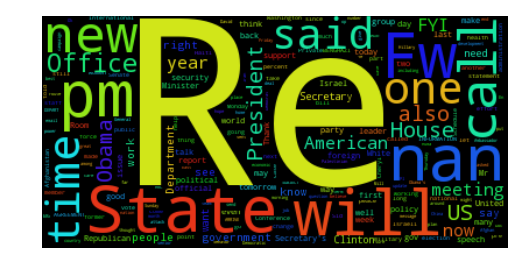

In [6]:
# Generate a word cloud image
wordcloud = WordCloud().generate(text_str)
plt.imshow(wordcloud)
plt.axis("off")

# WordCloud on Clean Data

In [17]:
from cleaner import *

# initiate Cleaner class
filter_list = ['nan']
cleaner = Cleaner(filter_list)
clean_text = cleaner.cleaning_pipeline(text_str)
clean_text[:1000]

'thursday march 2011 latest syria aiding qaddafi sid hrc memo syria aiding libya 030311 docx hrc memo syria aiding libya 030311 docx march 2011 hillary thx friday march 2011 huma abedin latest syria aiding qaddafi sid hrc memo syria aiding libya 030311 docx pis print pis print wednesday september 2012 russorv state gov meet wing extremist anti fvluslim film sparked deadly riots meat wednesday september 2012 subject meet wing extremist anti muslim film sparked deadly riots htte maxbiumenthal com12012 meet wing extremist anti musiim tihn sparked deadly riots verizon wireless lte droid department state case 2015 04841 doc c05739559 date 2015 state dept produced house select benghazi comm subject agreement sensitive information redactions foia waiver state 5cb0045251 friday march 2011 huma abedin latest syria aiding qaddafi sid hrc memo syria aiding libya 030311 docx pis print fyi wednesday september 2012 fwd libya libya sept docx sending direct verizon wireless lte druid fyi wednesday sep

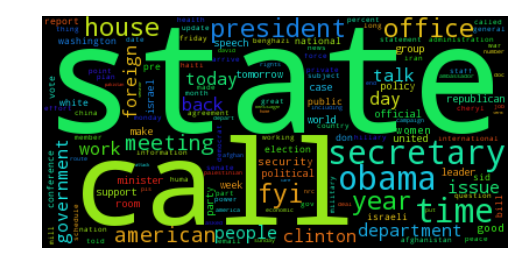

In [18]:
wc = WordCloud(max_words=1000)
wc.generate(clean_text)
plt.imshow(wc, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [29]:
trump_coloring = np.array(Image.open("./other/trump.png"))
wc_colored = WordCloud(max_words=3000, mask=trump_coloring, random_state=1)
wc_colored.generate(clean_text)

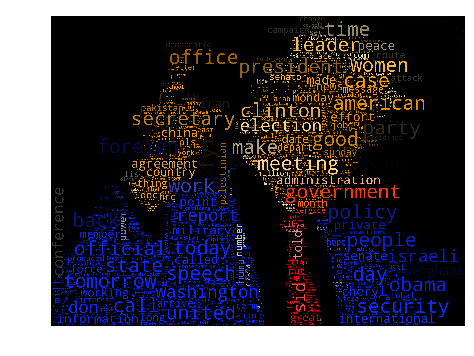

In [30]:
# create coloring from image
image_colors = ImageColorGenerator(trump_coloring)
plt.imshow(wc_colored.recolor(color_func=image_colors))
plt.axis("off")
plt.show()

In [27]:
wc.to_file("trump<3clinton2.png")


We should add a lot of different things in the stop words.. For example, we see that FYI is used a lot. I'm not really motivated to do that, therefore I let you do it. xoxo

# Sentimental Analysis on the countries

In [39]:
countries = {}

bullshit_countries = ["Antarctica"]

for country in pycountry.countries:
    if country.name not in bullshit_countries:
        list_to_search = []
        list_to_search.append(country.name.split(",")[0].lower())
        list_to_search.append(country.alpha_2)
        list_to_search.append(country.alpha_3)
        try:
            str_text = requests.get("https://restcountries.eu/rest/v1/alpha/" + country.alpha_2.lower()).text
            dic = json.loads(str_text)
            list_to_search.append(dic["capital"].lower())
        except:
            print(str_text)
            pass

        if country.name == "Syrian Arab Republic":
            list_to_search.append("syria")
        if country.name == "Russian Federation":
            list_to_search.append("russia")
        countries[country.name] = list_to_search

In [40]:
countries["UK"] = ['uk', 'united kingdom', 'great britain']
countries["United States"].append("U.S.")
countries["United States"].append("U.S.A.")

249

In [47]:
len(countries)

249

In [46]:
countries["United States"]

['united states', 'US', 'USA', 'washington, d.c.']

In [48]:
stopwords = list(STOPWORDS)

cited_countries = {}
for i in range(100):
    body = str(emails.iloc[i].ExtractedBodyText)
    body_lower = body.lower()
    subject = str(emails.iloc[i].ExtractedSubject).lower()
    
    body = body.split(" ")
    body.extend(body_lower.split(" "))
    
    subject = subject.split(" ")
    if body != "nan":  
        for ctr in countries:
            for citation in countries[ctr]:
                if (citation in body or citation in subject):
                    if ctr in cited_countries:
                        cited_countries[ctr]["nbr_citation"] += 1
                        cited_countries[ctr]["citation"].append(citation)
                    else:
                        subdic = {}
                        subdic["sentiment"] = []
                        subdic["average_sentiment"] = 0
                        subdic["nbr_citation"] = 1
                        subdic["citation"] = [citation]
                        cited_countries[ctr] = subdic
                    break
    

In [49]:
cited_countries

{'Andorra': {'average_sentiment': 0,
  'citation': ['AND', 'AND'],
  'nbr_citation': 2,
  'sentiment': []},
 'Armenia': {'average_sentiment': 0,
  'citation': ['AM', 'AM'],
  'nbr_citation': 2,
  'sentiment': []},
 'Chad': {'average_sentiment': 0,
  'citation': ['chad'],
  'nbr_citation': 1,
  'sentiment': []},
 'China': {'average_sentiment': 0,
  'citation': ['china'],
  'nbr_citation': 1,
  'sentiment': []},
 'Egypt': {'average_sentiment': 0,
  'citation': ['cairo',
   'egypt',
   'egypt',
   'egypt',
   'egypt',
   'egypt',
   'egypt',
   'egypt',
   'egypt'],
  'nbr_citation': 9,
  'sentiment': []},
 'France': {'average_sentiment': 0,
  'citation': ['france', 'france'],
  'nbr_citation': 2,
  'sentiment': []},
 'India': {'average_sentiment': 0,
  'citation': ['IN'],
  'nbr_citation': 1,
  'sentiment': []},
 'Iran, Islamic Republic of': {'average_sentiment': 0,
  'citation': ['iran', 'iran'],
  'nbr_citation': 2,
  'sentiment': []},
 'Iraq': {'average_sentiment': 0,
  'citation': ['